## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [12]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [17]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        print('batch len', len(batch))
        
        step_size = max_time / len(batch)
        
        x = torch.arange(0,max_time, step_size, dtype=torch.float64)
        
        print('x len', len(x))
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(13) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]   #value of min
        
        s[3] = np.nanmax(batch[x<4])   # local max
        
  
        s[4] = x[np.nanargmax(batch[x<4])]   #value of max

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[5] = np.nanmax(batch[(x>=4)&(x<8)])
            s[6] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4
            s[9] = np.nanmin(batch[(x>=4)&(x<8)])
            s[10] = x[np.nanargmin(batch[(x>=4)&(x<8)])] +4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[7] = np.nanmin(batch[x>=5])
            s[8] = x[np.nanargmin(batch[x>=5])] + 5
            
            s[11] = np.nanmax(batch[x>=5])
            s[12] = x[np.nanargmax(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [18]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

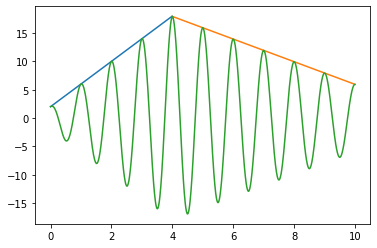

In [7]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [8]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

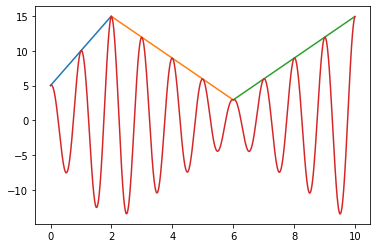

In [9]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [65]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

## First round

In [66]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_5183/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_5183/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [67]:
x = extract_sumstats(x_without)

batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x len 300
batch len 300
x 

In [68]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 64 epochs.


In [69]:
true_params = [5, 5]
obs_real = piecewise_linear_seq(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([300])
batch len 300
x len 300
torch.Size([1, 13])


In [70]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])
print(samples_0)

[tensor(4.6768), tensor(4.9669), tensor(4.5662), tensor(4.8891), tensor(4.9174), tensor(4.7379), tensor(5.2155), tensor(4.6204), tensor(5.5462), tensor(4.9608), tensor(5.4381), tensor(5.1728), tensor(5.0530), tensor(4.5616), tensor(4.6473), tensor(5.1612), tensor(4.7630), tensor(5.2462), tensor(3.7061), tensor(4.6798), tensor(5.3709), tensor(5.7011), tensor(4.7029), tensor(5.2309), tensor(4.9162), tensor(4.9415), tensor(4.8751), tensor(4.8644), tensor(4.8152), tensor(4.5794), tensor(4.0753), tensor(5.3316), tensor(4.6231), tensor(5.0870), tensor(4.9705), tensor(5.1326), tensor(4.9426), tensor(4.6797), tensor(4.8948), tensor(5.0463), tensor(5.1047), tensor(4.8278), tensor(4.8876), tensor(4.8529), tensor(4.7583), tensor(4.5893), tensor(3.7359), tensor(4.8668), tensor(4.6260), tensor(4.9186), tensor(5.0792), tensor(5.0854), tensor(5.0108), tensor(5.0259), tensor(5.0348), tensor(4.8961), tensor(5.1695), tensor(5.0819), tensor(4.8404), tensor(5.1220), tensor(5.1476), tensor(5.0702), tensor(

5.7010946
3.7060757


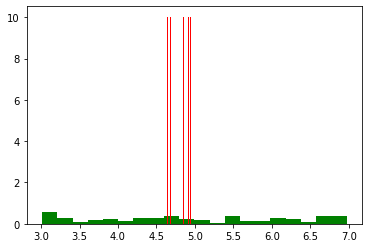

In [72]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.

plt.hist(data, 20, facecolor='green', density=True) 
plt.hist(samples_0, 20, facecolor='red', density=True)


print(np.max(samples_0))
print(np.min(samples_0))

In [73]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
1.995019


In [74]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [75]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[5.0731, 3.4929]])
theta prior tensor([[-3.0707]])
theta tensor([[ 5.0731,  3.4929, -3.0707]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.5881, 5.3036]])
theta prior tensor([[-3.1055]])
theta tensor([[ 4.5881,  5.3036, -3.1055]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[5.2448, 4.8434]])
theta prior tensor([[-1.8754]])
theta tensor([[ 5.2448,  4.8434, -1.8754]])
tensor([-1.9893])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.0316, 5.1463]])
theta prior tensor([[-3.7185]])
theta tensor([[ 5.0316,  5.1463, -3.7185]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.8255, 4.8522]])
theta prior tensor([[-3.6787]])
theta tensor([[ 4.8255,  4.8522, -3.6787]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[4.5210, 5.3081]])
theta prior tensor([[-3.6018]])
theta tensor([[ 4.5210,  5.3081, -3.6018]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[4.9639, 4.9763],
        [4.8231, 5.1199]])
theta prior tensor([[-4.7175],
        [-3.3550]])
theta tensor([[ 4.9639,  4.9763, -4.7175],
        [ 4.8231,  5.1199, -3.3550]])


/tmp/ipykernel_5183/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_5183/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[5.0714, 5.2599]])
theta prior tensor([[-1.3539]])
theta tensor([[ 5.0714,  5.2599, -1.3539]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[4.7905, 4.6903]])
theta prior tensor([[-4.8505]])
theta tensor([[ 4.7905,  4.6903, -4.8505]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[5.0061, 5.1574]])
theta prior tensor([[-4.3488]])
theta tensor([[ 5.0061,  5.1574, -4.3488]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 2])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[4.9212, 5.5167],
        [6.5872, 4.8469],
        [5.1285, 4.8971],
        [4.8134, 4.7444],
        [5.0456, 4.7632],
        [5.6088, 5.0541],
        [4.8403, 4.6849],
        [4.7474, 5.0060],
        [4.9149, 5.2702],
        [5.3285, 5.0497],
        [4.9302, 4.8612],
        [4.9861, 4.8079],
        [4.7856, 5.3617],
        [4.5327, 4.8892],
        [4.6416, 5.1615],
        [4.6011, 4.7210],
        [4.9991, 4.9583],
        [5.1864, 4.7343],
        [5.2926, 4.8375],
        [4.6479, 4.7951],
        [5.2035, 4.9197],
        [4.7996, 5.1123],
        [4.9086, 4.8251],
        [4.8755, 4.7963],
        [4.8412, 4.9005],
        [5.0698, 4.7539],
        [4.8954, 5.2242],
        [4.8401, 4.9606],
        [5.1321, 5.0348],
        [4.8982, 4.7864],
        [5.4084, 5.4082],
        [5.0240, 5.0508],
        [4.6258, 4.8967],
        [4.9919, 4.8528],
        [4.7678, 4.7513]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [76]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x len 600
batch len 600
x 

In [77]:
true_params = [5,5,-3]


obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

batch len 600
x len 600


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Third and last round

In [78]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[3:4], high = prior_max[3:4])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.9500,  5.3655, -3.0505]])
theta prior tensor([[2.6438]])
theta tensor([[ 4.9500,  5.3655, -3.0505,  2.6438]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8637,  5.1515, -3.4784]])
theta prior tensor([[3.7758]])
theta tensor([[ 4.8637,  5.1515, -3.4784,  3.7758]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.9490,  5.1145, -3.1570]])
theta prior tensor([[2.5655]])
theta tensor([[ 4.9490,  5.1145, -3.1570,  2.5655]])
tensor([0.1197])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.1072,  4.3488, -2.0638]])
theta prior tensor([[2.2469]])
theta tensor([[ 5.1072,  4.3488, -2.0638,  2.2469]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8193,  5.1060, -3.8153]])
theta prior tensor([[0.8665]])
theta tensor([[ 4.8193,  5.1060, -3.8153,  0.8665]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 4.8185,  5.0663, -3.3835]])
theta prior tensor([[0.8134]])
theta tensor([[ 4.8185,  5.0663, -3.3835,  0.8134]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 3])
theta prior size torch.Size([2, 1])
2
theta_posterior tensor([[ 4.9274,  4.9452, -3.1856],
        [ 5.0834,  4.9228, -3.3549]])
theta prior tensor([[3.0896],
        [1.0880]])
theta tensor([[ 4.9274,  4.9452, -3.1856,  3.0896],
        [ 5.0834,  4.9228, -3.3549,  1.0880]])


/tmp/ipykernel_5183/1402098608.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)
/tmp/ipykernel_5183/1402098608.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([3])
theta prior size torch.Size([1])
1
true
theta_posterior tensor([[ 5.0130,  5.2545, -3.3131]])
theta prior tensor([[0.2896]])
theta tensor([[ 5.0130,  5.2545, -3.3131,  0.2896]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 4.9936,  4.9937, -3.1082]])
theta prior tensor([[2.2798]])
theta tensor([[ 4.9936,  4.9937, -3.1082,  2.2798]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 3])
theta prior size torch.Size([1, 1])
2
theta_posterior tensor([[ 5.2592,  4.9604, -3.6591]])
theta prior tensor([[0.4813]])
theta tensor([[ 5.2592,  4.9604, -3.6591,  0.4813]])


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

theta pos size torch.Size([300, 3])
theta prior size torch.Size([300, 1])
2
theta_posterior tensor([[ 4.9648,  5.0444, -3.4218],
        [ 5.0868,  4.9150, -3.3222],
        [ 4.8059,  5.0000, -2.7525],
        [ 5.0742,  5.0728, -3.1111],
        [ 4.9525,  4.8269, -3.3337],
        [ 4.7877,  5.1272, -3.4328],
        [ 4.8047,  5.3959, -3.8203],
        [ 5.0438,  4.9326, -3.4920],
        [ 4.8165,  4.7790, -3.3026],
        [ 5.6330,  5.4019, -3.1812],
        [ 4.8952,  5.0540, -3.3533],
        [ 4.7701,  4.8445, -4.7586],
        [ 5.0579,  5.4553, -3.3207],
        [ 4.7675,  5.1242, -3.2627],
        [ 4.7427,  5.1334, -3.2404],
        [ 4.8165,  4.9792, -4.2730],
        [ 4.8462,  5.0489, -3.2916],
        [ 4.8922,  4.8629, -4.6487],
        [ 5.2658,  4.9446, -3.2810],
        [ 4.9754,  5.0070, -4.3625],
        [ 4.6488,  4.9764, -3.6245],
        [ 4.8491,  5.0254, -4.9339],
        [ 4.8207,  5.0605, -3.3859],
        [ 5.0317,  5.0299, -3.3823],
        [ 5.0421,  5

theta prior tensor([[1.8011],
        [3.3777],
        [2.2729],
        [2.1301],
        [3.5571],
        [1.5425],
        [2.7883],
        [0.0917],
        [1.5151],
        [1.3502],
        [1.0249],
        [3.8416],
        [2.9309],
        [2.9782],
        [2.5480],
        [2.5856],
        [0.9961],
        [1.6893],
        [2.6096],
        [3.9183],
        [1.1979],
        [0.8553],
        [0.1707],
        [0.2533],
        [1.8968],
        [2.1157],
        [3.5027],
        [2.6827],
        [0.8922],
        [1.5017],
        [3.8848],
        [3.7791],
        [2.7755],
        [0.9742],
        [3.8364],
        [0.5020],
        [2.9134],
        [0.3269],
        [3.6011],
        [1.5468],
        [3.5275],
        [1.2711],
        [0.1365],
        [1.1819],
        [3.4007],
        [2.3847],
        [1.9752],
        [2.5826],
        [3.9300],
        [3.2507],
        [3.1290],
        [0.1604],
        [1.7374],
        [1.2306],
        [1.8601]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [79]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 1000
x len 1000
batch len 10

In [80]:
true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])


samples = posterior3.sample((num_samples,), x=obs_real_stats)

batch len 1000
x len 1000


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [81]:
end = get_time()


print('start:', start, '\nend:', end)

start: 12-08-2021_10:59:20 
end: 12-08-2021_11:48:30


In [82]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)

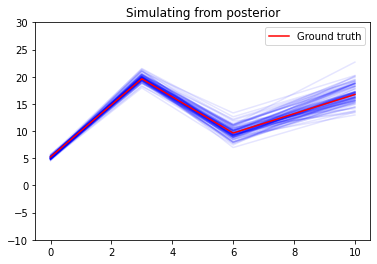

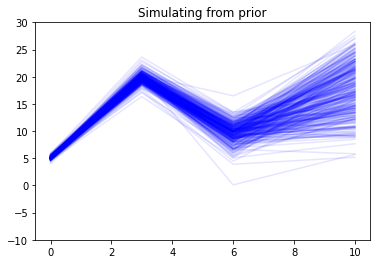

In [83]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

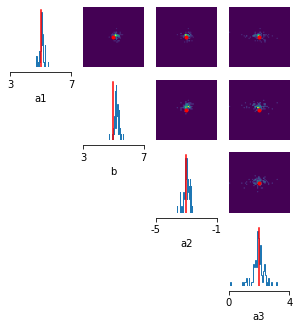

In [44]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3', 'cp1', 'cp2' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

torch.Size([1000, 13])
100
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])


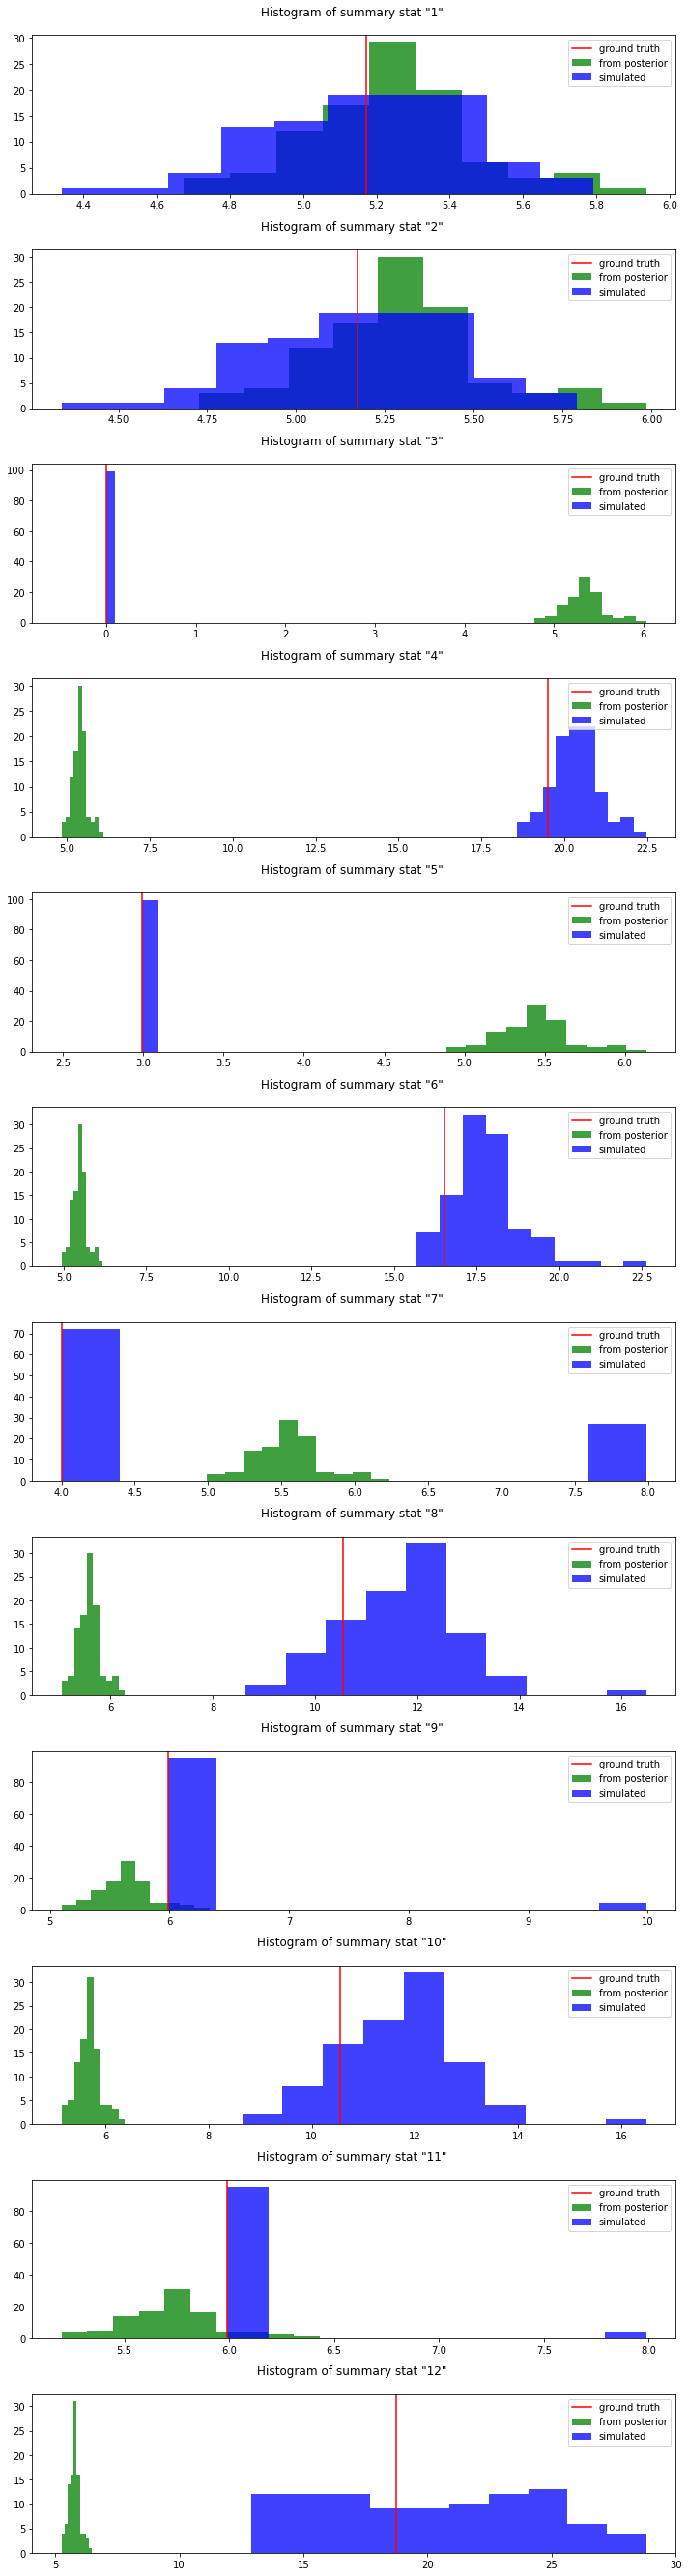

In [45]:
import matplotlib.gridspec as gridspec

x = x

s_real = obs_real_stats[0]



print(x.shape)


print(len(s_x))

fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)


sum_stats_names = torch.arange(1, 14, 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x[j][i])
        globals()['x%s' % i].append(x[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(s_real[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')